In [1]:
import torch    
from Classifier_NN import Classifier_NN
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from NObSP_Decomposition import NObSP_NN_single_MultiOutput
import torch.nn.functional as F

In [2]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(2, 2))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [3]:
# Cargar los tensores guardados
images = torch.load('train_images_mnist.pth')
X = torch.load('train_tensors_mnist.pth')
y = torch.load('train_labels_mnist.pth')

X = torch.cat(X).detach()
y = F.one_hot(torch.cat(y))

labels = tuple(str(i) for i in range(10))

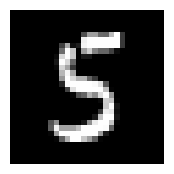

In [4]:
imshow(torchvision.utils.make_grid(images[1000]))

In [5]:
X_sample = []
y_sample = []
index_used = []

sample_size = 150
# Supongamos que 'num_classes' es el número de clases en tus etiquetas
for i in range(10):
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    index_used.append(indices)
    X_sample.append(X[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

index_used = [tensor.item() for sublist in index_used for tensor in sublist]
images_sample = [images[i] for i in index_used]
X_sample = torch.cat(X_sample)
y_sample = torch.cat(y_sample)

In [6]:
X_sample.shape

torch.Size([1500, 288])

In [7]:
N = np.size(X_sample, 0); # Defining the number of datapoints
in_feat = np.size(X_sample, 1)

In [8]:
t = np.arange(0, N)
train_split = int(0.8 * N)
p = 10

In [9]:
epochs = 200
learning_rate = 0.001

In [10]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    train_size = train_split,
    random_state=42
) 

## Creating model for single nonlinear effects

model_1 = Classifier_NN(in_number=X_sample.shape[1], out_number=y_sample.shape[1]) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training loop for the model 1

In [11]:
for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_prob, x_p, y_lin = model_1(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.29700 | test Loss: 2.25066
Epoch: 10 | Loss: 1.69341 | test Loss: 1.63076
Epoch: 20 | Loss: 1.52104 | test Loss: 1.51822
Epoch: 30 | Loss: 1.49118 | test Loss: 1.50636
Epoch: 40 | Loss: 1.47980 | test Loss: 1.49944
Epoch: 50 | Loss: 1.47308 | test Loss: 1.50155
Epoch: 60 | Loss: 1.46926 | test Loss: 1.50256
Epoch: 70 | Loss: 1.46845 | test Loss: 1.50108
Epoch: 80 | Loss: 1.46819 | test Loss: 1.49899
Epoch: 90 | Loss: 1.46807 | test Loss: 1.49935
Epoch: 100 | Loss: 1.46799 | test Loss: 1.49924
Epoch: 110 | Loss: 1.46795 | test Loss: 1.49914
Epoch: 120 | Loss: 1.46792 | test Loss: 1.49926
Epoch: 130 | Loss: 1.46789 | test Loss: 1.49927
Epoch: 140 | Loss: 1.46787 | test Loss: 1.49933
Epoch: 150 | Loss: 1.46785 | test Loss: 1.49934
Epoch: 160 | Loss: 1.46784 | test Loss: 1.49936
Epoch: 170 | Loss: 1.46782 | test Loss: 1.49940
Epoch: 180 | Loss: 1.46781 | test Loss: 1.49957
Epoch: 190 | Loss: 1.46779 | test Loss: 1.49982


In [12]:
correct = 0
total = 0

model_1.eval()
with torch.inference_mode():
    outputs, _, _ = model_1(X_test)
    for tensor, label in zip(outputs, y_test):
        predicted = torch.argmax(tensor)
        label = torch.argmax(label) 
        total += 1
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.3f} %')

Test Accuracy: 96.000 %


In [13]:
model_1.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = model_1(
        X_sample
    )  # Computing the nonlinear transformation of the input data X

P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single_MultiOutput(
    X_sample, y_est_1, model_1
)  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer

y_e_Alpha_1 = np.zeros((N, in_feat, p))
for i in range(p):
    y_e_Alpha_1[:, :, i] = (
        x_trans_total_1 @ Alpha_NN_1[:, i * in_feat : i * in_feat + in_feat]
    )  # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu()

In [14]:
X_sample.shape

torch.Size([1500, 288])

In [15]:
y_e_1.shape

torch.Size([1500, 288, 10])

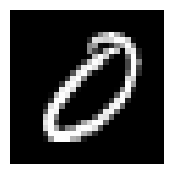

In [16]:
imshow(torchvision.utils.make_grid(images_sample[0]))

In [18]:
y_e_1[0, 0, :]

tensor([ 0.0021, -0.0007, -0.0017, -0.0040,  0.0018,  0.0006,  0.0011,  0.0011,
         0.0004,  0.0011])